In [4]:
from IPython.display import HTML

In [8]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## 3.7 LSH Families for Other Distance Measures

Neste capítulo são apresentadas outras famílias de funções LSH para algumas medida de distância. 

É dito que não há garantias que exista uma família de funções LSH para toda medida de distância.

### 3.7.1 LSH Families for Hamming Distance

A distância de Hamming entre dois vetores $x$ e $y$ é calculado como **o número de componentes de $x$ e $y$ que possuem valores diferentes**.

In [3]:
points_h = np.array([
    [1, 2, 3, 6],
    [1, 2, 5, 1],
    [4, 2, 5, 9],
    [1, 5, 1, 6]
])
points_as_str = [str(p).replace(' ', ',') for p in points_h]

# a definição aqui é #diferente/#length
hamming = DistanceMetric.get_metric("hamming")
pd.DataFrame(hamming.pairwise(points_h) * 4, 
             columns=points_as_str,
             index=points_as_str)

,"[1,2,3,6]","[1,2,5,1]","[4,2,5,9]","[1,5,1,6]"
"[1,2,3,6]",0.0,2.0,3.0,2.0
"[1,2,5,1]",2.0,0.0,2.0,3.0
"[4,2,5,9]",3.0,2.0,0.0,4.0
"[1,5,1,6]",2.0,3.0,4.0,0.0


Sejam:

* $l$ o tamanho dos vetores sobre os quais é calculada a distância de Hamming;
* $d1, d2 \in \{0, 1, ..., l\}$
* $h_i(x) = x[i], i \in \{0, 1, ..., l - 1\}$

Se $d(x, y) = d_1$, a probabilidade de, para uma posição $i \in \{0, 1, ..., l - 1\}$ selecionada aleatoriamente, $h_i(x) = h_i(y)$ é de $1 - \frac{d_1}{l}$, isto é, o complemento da probabilidade de que seja selecionada uma posição cujos valores de $x$ e de $y$ sejam diferentes.

$F_{d1, d2} (d_1, d_2, 1 - \frac{d1}{l}, 1 - \frac{d2}{l}) - sensitive$

* se $d(x,y) \le d_1$ então $Pr[h_i(x) = h_i(y)] \ge 1 - \frac{d1}{l}$
* se $d(x,y) \ge d_2$ então $Pr[h_i(x) = h_i(y)] \le 1 - \frac{d2}{l}$


Por exemplo, para $d_1 = 1$ e $l = 10$, $1 - \frac{d1}{l} = 0.9$. Veja que $d(x,y) \le 1$ indica que a quantidade de posições em que $x$ e $y$ possuem mesmo valor é maior ou igual a 9, de um valor máximo igual a 10. Dessa forma, a probabilidade de que, selecionando aleatoriamente uma posição, os valores em $x$ e em $y$ para essa posição sejam iguais é de $0.9$.

In [56]:
def hamming_lsh(length, n):
    
    # selecionado aleatoriamente com ou sem reposição?
    index = np.random.choice(np.arange(0, length, 1), n, replace=False)
    
    return index, lambda x: x[:, index].reshape((length, n))

index, h = hamming_lsh(4, 2)

print("Indexes selecionados: {}".format(index))
pd.DataFrame(hamming.pairwise(h(points)), 
             columns=points_as_str,
             index=points_as_str)

Indexes selecionados: [2 0]


,[1 2 3 6],[1 2 5 1],[4 2 5 9],[1 5 1 6]
[1 2 3 6],0.0,0.5,1.0,0.5
[1 2 5 1],0.5,0.0,0.5,0.5
[4 2 5 9],1.0,0.5,0.0,1.0
[1 5 1 6],0.5,0.5,1.0,0.0


### 3.7.2 Random Hyperplanes and the Cosine Distance

<img src="images/cosine_lsh.png" />

Dois vetores $x$ e $y$ formam um ângulo $\theta$(distância cosseno) entre si e determinam um plano(conjunto de vetores da forma $\alpha x + \beta y$ com $\alpha$ e $\beta$ escalares). 

A interseção entre o plano determinado por $x$ e $y$ e um hiperplano, determinado por um vetor unitário $v$ que passe pela origem, é uma reta, dividindo o plano em duas partes[1]. 

$x$ e $y$ encontram-se no mesmo lado do plano dividido se e somente se $sign(v.x) = sign(v.y)$

Sejam:

* $v$ o vetor unitário que determina o hiperplano(conjunto de vetores $r$ com $v.r = 0$);
* $h_v(x) = sign(v.x)$

Se $d(x, y) = \theta$, a probabilidade de $h_v(x) = h_v(y)$ é de $\frac{180 - \theta}{180}$, isto é, a probabilidade de a reta determinada pela interseção do hiperplano com o plano determinado por $x$ e $y$ divida o plano de forma que $x$ e $y$ fiquem localizados do mesmo lado($180$ graus, total, menos $\theta$, parte coberta pelos vetores $x$ e $y$).

$F_{v} (\theta_1, \theta_2, \frac{180 - \theta_1}{180}, \frac{180 - \theta_2}{180}) - sensitive$

* se $d(x,y) \le \theta_1$ então $Pr[h_v(x) = h_v(y)] \ge \frac{180 - \theta_1}{180}$
* se $d(x,y) \ge \theta_2$ então $Pr[h_v(x) = h_v(y)] \le \frac{180 - \theta_2}{180}$


[1] - e o caso de $v.x = 0$?

In [131]:
from sklearn.preprocessing import normalize

def cosine_lsh(length):

    v = normalize(np.random.standard_normal(length).reshape(1, -1))[0, :]
    
    return v, lambda x: np.sign(x.dot(v))

In [147]:
points = np.array([
    [2, 7],
    [-6, 4],
    [14, 1],
    [20, 32]
])
points_as_str = [str(p) for p in points]

v, h = cosine_lsh(2)

print("Vetor: {}".format(v))
pd.DataFrame(h(points), 
             index=points_as_str)

Vetor: [-0.97755707 -0.21067079]


,0
[2 7],-1.0
[-6 4],1.0
[14 1],-1.0
[20 32],-1.0


<IPython.core.display.Javascript object>


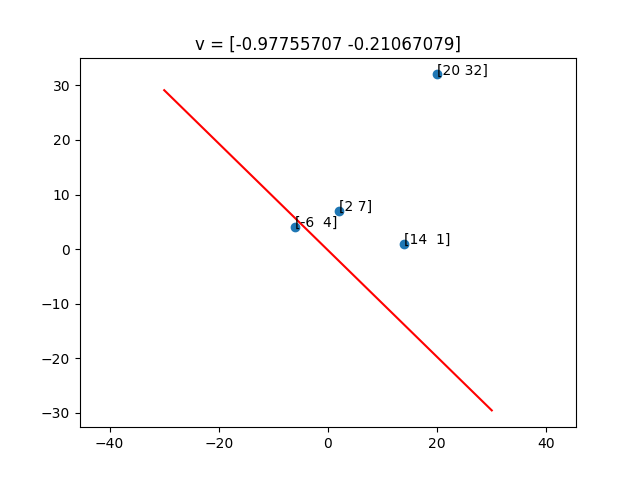

In [148]:
fig, ax = plt.subplots(1, 1)
ax.scatter(points[:, 0], points[:, 1])
x_line = np.linspace(-30, 30, 100)
ax.plot(x_line, x_line*v[0] + v[1], c='r')
ax.set_title("v = {0}".format(v))
ax.axis("equal")

for i, point in enumerate(points):
    ax.annotate(str(point), (point[0], point[1]))

In [57]:
@interact(d1 = (0, 180, 10), d2 = (0, 180, 10))
def cosine_lsh_family(d1, d2):
    
    p1 = (180 - d1)/180
    p2 = (180 - d2)/180
    
    print('({0}, {1}, {2}, {3}) - sensitive'.format(d1, d2, p1, p2))
    display(Math(r'se\ d(x,y) \le {d1}º\ então\ Pr[h(x) = h(y)] \ge {p1}'.format(d1=d1, p1=p1)))
    display(Math(r'se\ d(x,y) \ge {d2}º\ então\ Pr[h(x) = h(y)] \le {p2}'.format(d2=d2, p2=p2)))

### 3.7.3 Sketches

\# TODO

### 3.7.4 LSH Families for Euclidean Distance

$L_2-norm$ ou distância euclidiana<br />
$d([x_1, x_2, ..., x_n], [y_1, y_2, ..., y_n]) = \sqrt{\sum\limits_{i = 1}^n (x_i - y_i)^2}$

Sejam:

* $l$ uma linha aleatoriamente selecionada e dividida em buckets identificados de tamanho $a$;
* $x$ e $y$ dois pontos com $d(x, y) = z$;
* $h_{l, a}(x) =$ identificação do bucket que contém a projeção ortogonal de $x$ em $l$

Quanto mais a distância entre $x$ e $y$ for menor que $a$, o tamanho dos buckets, maior a chance de que $h_{l, a}(x) = h_{l, a}(y)$. 

Para $d(x, y) = \frac{a}{2}$, por exemplo, a chance de $x$ e $y$ serem projetados no mesmo bucket é de no mínimo 50%, no caso de o ângulo formado entre o segmento de reta compreendido entre $x$ e $y$ e a reta $l$ ser de 0º, isto é, o segmento de reta e a reta serem paralelos.

<img src="images/euclidean_lsh.png" />

In [150]:
@interact(d1 = (0, 180, 10), d2 = (0, 180, 10))
def cosine_lsh_family(d1, d2):
    
    p1 = (180 - d1)/180
    p2 = (180 - d2)/180
    
    print('({0}, {1}, {2}, {3}) - sensitive'.format(d1, d2, p1, p2))
    display(Math(r'se\ d(x,y) \le {d1}º\ então\ Pr[h(x) = h(y)] \ge {p1}'.format(d1=d1, p1=p1)))
    display(Math(r'se\ d(x,y) \ge {d2}º\ então\ Pr[h(x) = h(y)] \le {p2}'.format(d2=d2, p2=p2)))

<IPython.core.display.Javascript object>


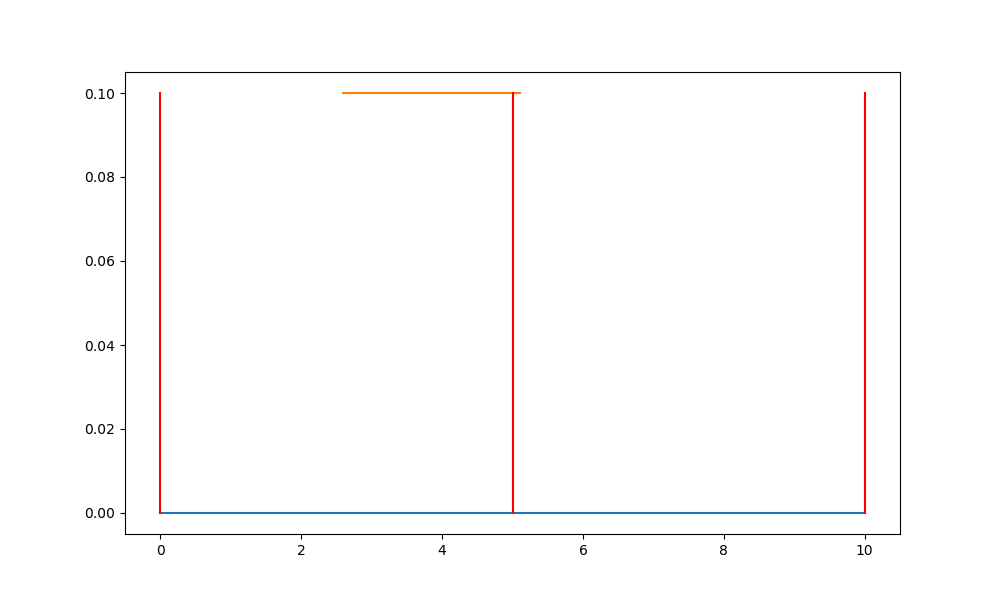

In [153]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

ax.plot([0, 10], [0, 0])
l1, = ax.plot([0, 2.5], [.1, .1])
ax.plot([0, 0], [0, .1], c='r')
ax.plot([5, 5], [0, .1], c='r')
ax.plot([10, 10], [0, .1], c='r')

@interact(ini=(0, 10, .1))
def plot_line_buckets(ini = 0):
    
    l1.set_xdata((ini, ini + 2.5))
    fig.canvas.draw()

fig.show()

### 3.7.5 More LSH Families for Euclidean Spaces

\# TODO

## 3.8 Applications of Locality-Sensitive Hashing

### 3.8.1 Entity Resolution

O problema chamado **Entity Resolution** consiste em identificar se dois documentos referem-se à mesma entidade. Por exemplo, duas lojas online podem ter em seus cadastros dados diferentes de uma mesma pessoa, como:

**Loja 1**:

**nome**: Abelardo V. Mota

**idade**: 27 anos

**Loja 2**:

**nome**: Abelardo Vieira Mota

**data de nascimento**: 29/11/1989

Dois documentos que se refiram à mesma entidade podem diferir quanto:

* **formato**. ex: um ser um registro CSV, o outro ser um texto em linguagem natural;
* **conjunto de atributos**. ex: um pode possuir o atributo *idade*, o outro *data de nascimento*;
* **representação dos atributos**. ex: em um dos documentos o nome pode vir abreviado e no outro não;
* **erro**. ex: uma informação pode estar errada em um dos documentos;
* **informação desatualizada**. ex: os registros possuem telefones utilizados em períodos diferentes.

### 3.8.2 An Entity-Resolution Example

A **empresa A** atua direcionando clientes para a **empresa B**, sendo paga quando estes mantêm assinaturas de serviços na empresa B.

Em determinado momento as duas empresas entraram em desacordo sobre quantos clientes a **empresa A** havia direcionado para a **empresa B**. As duas empresas possuem $10^6$ registros de clientes, não havendo informação que relacione um registro de cliente da **empresa B** a um registro de cliente da **empresa A**.

Para descobrir quais registros de clientes entre as bases das duas empresas referem-se aos mesmos clientes, uma solução é compará-los e, utilizando critérios de similaridade, selecionar aqueles mais semelhantes.

A comparação de todos os registros da **empresa A** com todos os registros da **empresa B** gerará $10^6 \times 10^6 = 10^{12}$ comparações.

A fim de diminuir a quantidade de comparações necessárias, a seguinte estratégia pode ser utilizada:

* são definidas funções de score para os atributos dos registros, indicando o quanto dois registros são similares, de acordo com os valores do atributo. O score possui valor no range [0, 100].
* a soma dos scores de todos os atributos para dois registros indica quão similares são os registros.
* para cada atributo A, os registros das duas bases serão agrupados por A(**mesmos valores de A**) e será calculado o score de cada par de registros em cada grupo.
* após esse processo, serão selecionados como prováveis registros de mesma entidade aqueles cujo score seja maior que um determinado valor(a ser explicado na próxima seção).

Dessa forma, são calculados os scores apenas dos pares que sejam iguais para pelo menos um atributo.

$R_A \gets$ registros da empresa A;

$R_B \gets$ registros da empresa B;

$R \gets R_A \cup R_B$;

$F \gets \{nome, endereço, telefone\}$;

$score(f, x, y)\gets$ o valor da função de score para o atributo $f$ aplicada aos registros $x$ e $y$;

**para cada** $f$ **em** $F$:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**para cada** grupo $S$ **em** $R$ agrupado por $f$:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**para cada** par $(x, y)$ **em** $S$, com $x\in R_A$ e $y\in R_B$ e cujo score ainda não esteja registrado:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$score_{(x,y)}\gets score(f, x, y)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$registrar\_score(x, y, score_{(x, y)})$

Como funções de score, pode-se utilizar, por exemplo, a *edit distance* para campos string, escalando o seu valor para o range [0, 100], possivelmente compondo ela com outras funções, como uma tabela de lookup, contendo valores predeterminados, no caso de seu valor não representar bem a similaridade entre as entidades. Por exemplo, para os valores "Francisco" e "Chico", a *edit distance* é igual a 6, mas são nomes que tem grande chance de estarem representando a mesma informação, "Francisco".

\# falar exemplo de scoring

### 3.8.3 Validating Record Matches

Como determinar se dois registros referem-se à mesma entidade a partir do score atribuído a eles?

Para o problema em questão, foi determinado que um pré-requisito para que um registro $a$ da **empresa A** refira-se à mesma entidade de um registro $b$ da **empresa B** é que a data de criação de $b$ tenha sido no máximo 90 dias após a data de criação de $a$. Assume-se que a diferença entre as datas de criação desses registros, denominado delay, tem média igual a 45 dias.

Para os dados do problema, foi calculada a média do delay dos registros com match perfeito(score = 300), dando um valor de 10 dias.

* premissa: delay médio de registros com delay menor ou igual a 90 é 45 dias;
* com base nos dados:delay médio dos registros com score perfeito é 10 dias dias; 

O seguinte esquema é utilizado para se calcular uma estimativa da probabilidade de um par de registros com score $s$ referirem-se à mesma entidade:

1. Seja $x_s$ o delay médio para o conjunto de pares com score $s$;
2. $x_s$ pode ser calculado como $x_s = 10f_s + 45(1 - f_s)$, sendo $f_s$ a proporção de true matches dentro do conjunto de pares com score $s$[1];
3. Resolvendo para $f_s$, temos $f_s = \frac{45 - x_s}{35}$

Para os dados do exemplo, foi verificado que $f_s$ para registros com scores entre [185, 300] tinha valor próximo de 10, a média de delay para registros com score 300, sendo isso utilizado como indicativo de serem true matches.

Pode-se determinar um valor de score mínimo indicativo de true match analisando-se o valor de $f_s$ e sua proximidade com o valor da média de delay para true matches.

Abstraindo, esse esquema de determinar o valor mínimo do score consiste em:

1. Utilizar a distribuição de um atributo $X$ não utilizado no cálculo do score para tentar inferir a proporção de true matches, $f_s$, para um conjunto de registros com determinado score $s$.

Sejam:

* $h_1\gets$ a média de $X$
* $h_0\gets$ a média de $X$ para os registros que sejam true matches
* $h_s\gets$ a média de $X$ para os registros com score $s$
* $h_s = f_s h_0 + (1 - f)h_1$

Resolvendo a equação para $f_s$, temos:

$f_s = \frac{h_1 - h}{h_1 - h_0}$




[1] - Não entendi como chegar nessa equação... Não entendi o resto :) Acho que assume que a frequência de true matches tem média de delay igual a 10, a de false matches igual a 45, e que essa frequência é a mesma para a população toda e para as subpopulações por valor de score...

### 3.8.4 Matching Fingerprints

Minutia, no contexto de descrição de digital, é uma região da digital em que um padrão não comum está presente.

Uma forma de localizar minutiae é aplicar uma grid sobre a digital e identificar os grid squares onde uma minutia ocorre, dessa forma representando uma digital pelo conjunto de square grids onde estão presentes minutiae. 

Para comparação entre duas digitais, utiliza-se alguma métrica de comparação de conjuntos, sendo importante que suas imagens estejam com mesmas escala e orientação.

<img src="images/fingerprint_minutia.gif" />

Existem dois tipos de uso de comparação de fingerprints:

* **many-one**: compara-se um fingerprint com uma base de fingerprints em busca de matches. Por exemplo, uma busca pela pessoa por trás de uma digital encontrada em uma cena de crime.
* **many-many**: compara-se dois-a-dois um conjunto de fingerprints, em busca de matches. Por exemplo, deduplicação de uma base de digitais.

### 3.8.5 A LSH Family for Fingerprint Matching

Para não ter que comparar todos os pares de digitais para descobrir se duas digitais são similares, uma estratégia que pode ser utilizada é utilizar funções hash sobre as digitais, comparando apenas os pares em um mesmo bucket.

Para o problema em questão, o autor assume as seguintes informações:

* a probabilidade de haver uma minutia em um grid square aleatório é 20%;
* dado que há uma minutia em um grid square de uma digital, a probabilidade de haver uma minutia no mesmo grid square em outra digital do mesmo dedo é 80%;
* sejam $s_1, s_2, s_3$ grid squares aleatoriamente selecionados
* $x[s_1]$ o grid square $s_1$ da digital $x$
* $has\_minutia(s)$ uma função que responde True caso haja uma minutia no grid square s, False, caso contrário
* $f_{s_1, s_2, s_3}(x) = has\_minutia(x[s_1]) \wedge has\_minutia(x[s_2]) \wedge has\_minutia(x[s_3])$

Dada uma função $f_{s_1, s_2, s_3}$, as seguintes probabilidades podem ser calculadas:

1. probabilidade de duas digitais de dedos diferentes terem mesmo valor para $f$ True: $(0,2)^3 \times (0,2)^3 = 0,000064$, isto é, a probabilidade de haver minutia nos 3 grid squares de cada digital;(obs: acho estranho porque a informação que há de 20% é para uma digital aleatória... dado que são de digitais diferentes, a probabilidade pode ser diferente...)
2. probabilidade de duas digitais de mesmo dedo terem mesmo valor para $f$ True = probabilidade de uma digital cair no True e, dado isso, de a outra, de mesmo dedo, possuir minutia nos mesmos square grids: $(0,2)^3 \times (0,8)^3 = 0,004096$

||Positivo|Negativo|
|-|-|-|
|**True**|0,4096%%|99,5904%|
|**False**|0,0064%%|99,9936%|

Compondo funções $f_{s_1, s_2, s_3}$ através de operações **ou**, podemos manipular as probabilidades acima. 

Seja $\delta$ um conjunto de funções $f_{s_1, s_2, s_3}$ selecionadas aleatoriamente, e $F_{\delta}(x) = F_\delta(y) \leftrightarrow \bigvee_{f \in \delta} f(x) = f(y)$

Calculando as probabilidades para $F$ temos:

1. $1 - (1 - 0,000064)^{1024} = 0,063$

2. $1 - (1 - 0,004096)^{1024} = 0,985$

||Positivo|Negativo|
|-|-|-|
|**True**|98,5%|1,5%|
|**False**|6,3%|93,7%|

In [155]:
s = """
||Positivo|Negativo|
|-|-|-|
|**True**|{0:.2f}%|{1:.2f}%|
|**False**|{2:.2f}%|{3:.2f}%|
"""

print("p1 = probabilidade de haver uma minutia em um grid square\np2 = probabilidade de haver uma minutia em um grid square dado que há em outra digital de mesmo dedo")

@interact(p1 = (0, 1, 0.1), p2 = (0, 1, 0.1), nand = (0, 1024, 2))
def display_tf_pn(p1 = .2, p2 = .8, nand = 1):
    
    tp = (1 - (1 - (p1**3 * p2**3))**nand)*100
    fp = (1 - (1 - (p1**6))**nand)*100
    tn = 100 - tp
    fn = 100 - fp
    
    display(Markdown(s.format(tp, tn, fp, fn)))

p1 = probabilidade de haver uma minutia em um grid square
p2 = probabilidade de haver uma minutia em um grid square dado que há em outra digital de mesmo dedo


### 3.8.6 Similar News Articles

O problema *similar news articles* consiste na descoberta de conjuntos de documentos que possuam o mesmo conteúdo principal. 

É comum agências de jornalismo fornecerem conteúdo para que seja publicado em diversos meios de comunicação. Esses meios, a exemplo de sites de notícia, publicam esse conteúdo e a ele agregam outros conteúdos, como propagandas, artigos relacionados e informações sobre o site, possivelmente fazendo alterações no conteúdo dos artigos, removendo trechos, por exemplo. 

Para resolver este problema, é necessário ser capaz de separar o conteúdo principal das demais partes do artigo(conteúdo secundário). Uma forma de fazer isso é utilizando a diferença de distribuição de stopwords entre o conteúdo principal e o conteúdo secundário. Por exemplo:

1. **exemplo de texto de propaganda**: Compre Motorola G5 32GB
2. **exemplo de texto de conteúdo principal**: **O** Motorola Moto G5 é **um** smartphone Android avançado **e** abrangente **em** todos **os** pontos **de** vista **com** algumas características excelentes.

Assumindo que em strings de conteúdo principal *stopwords* sejam bem mais presentes que em strings de conteúdo secundário, podemos definir uma forma de *shingle* que exige a presença de uma *stopword*: um *shingle* é definido como uma sequência de *stopwords* e as duas próximas words.

Os conjuntos de *shingles* para os exemplos apresentados são:

1. { }
2. {"O Motorola Moto", "um smartphone Android", "e abrangente em", "em todos os", "os pontos de", "de vista com", "com algumas características"}

Suponha, por exemplo, duas páginas web que compartilhem o mesmo conteúdo principal, mas que difiram no conteúdo secundário. Dado que o conteúdo secundário contribua pouco para o conjunto de *shingles* dessas páginas, o conjunto de *shingles* das duas páginas será, em sua maior parte, determinado pelo conteúdo principal delas. Como possuem mesmo conteúdo, seus conjuntos de *shingles* serão bastante similares.

Se utilizássemos *shingles* definidos sobre caracteres(por exemplo 3-char-gram), o conjunto de *shingles* das duas páginas sofreria maior influência do conteúdo secundário, que não é o que se quer comparar neste problema.

\# exemplo?